## General Setup

In [1]:
import os

import numpy as np

import keras
from keras.applications import mobilenet_v2, imagenet_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator

import tensorflow

Using TensorFlow backend.


In [2]:
np.random.seed(4096)
tensorflow.set_random_seed(4096)

In [14]:
IMAGE_W = 224
IMAGE_H = 224

EPOCHS = 5
INITIAL_LR = 0.0005
BATCH_SIZE = 32

TRAIN_IMAGES_DIRECTORY = '/home/sam/Documents/Workspace/bad-cat/train_images'

KERAS_MODEL_FILE = 'cat_classifier.h5'
TFLITE_MODEL_FILE = 'cat_classifier.tflite'

## Setup Image Generators

In [4]:
image_generator = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=mobilenet_v2.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

training_generator = image_generator.flow_from_directory(
    TRAIN_IMAGES_DIRECTORY,
    target_size=(IMAGE_W, IMAGE_H),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = image_generator.flow_from_directory(
    TRAIN_IMAGES_DIRECTORY,
    target_size=(IMAGE_W, IMAGE_H),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 6460 images belonging to 3 classes.
Found 1614 images belonging to 3 classes.


In [5]:
labels = [item[0] for item in sorted(training_generator.class_indices.items(), key=lambda item: item[1])]

import pickle
with open('labels.pickle', 'wb') as f:
    pickle.dump(labels, f)

## Define Model

In [6]:
mobilenet_model = mobilenet_v2.MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_W,IMAGE_H,3)
)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
for layer in mobilenet_model.layers:
    layer.trainable = False

x = mobilenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.25)(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate=0.25)(x)
x = Dense(training_generator.num_classes, activation='softmax')(x)

model = Model(inputs=mobilenet_model.input, outputs=x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

## Warm Up Model

In [9]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = SGD(lr=INITIAL_LR),
    metrics=['accuracy']
)

H = model.fit_generator(
    training_generator,
    validation_data=validation_generator,
    steps_per_epoch=training_generator.samples / training_generator.batch_size,
    validation_steps=validation_generator.samples / validation_generator.batch_size,
    epochs=3,
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
202/201 [==============================] - 120s 596ms/step - loss: 0.9239 - acc: 0.5887 - val_loss: 0.8927 - val_acc: 0.4895
Epoch 2/3
202/201 [==============================] - 114s 566ms/step - loss: 0.7264 - acc: 0.7506 - val_loss: 0.7792 - val_acc: 0.5489
Epoch 3/3
202/201 [==============================] - 114s 564ms/step - loss: 0.5798 - acc: 0.8370 - val_loss: 0.6850 - val_acc: 0.6103


## Train Entire Model

In [10]:
for layer in mobilenet_model.layers:
    layer.trainable = True

model.compile(
    loss='categorical_crossentropy',
    optimizer = SGD(lr=INITIAL_LR),
    metrics=['accuracy']
)

H = model.fit_generator(
    training_generator,
    validation_data=validation_generator,
    steps_per_epoch=training_generator.samples / training_generator.batch_size,
    validation_steps=validation_generator.samples / validation_generator.batch_size,
    epochs=EPOCHS,
    callbacks=[
        ModelCheckpoint(KERAS_MODEL_FILE, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    ]
)

Epoch 1/5
202/201 [==============================] - 148s 730ms/step - loss: 0.3760 - acc: 0.9248 - val_loss: 0.2732 - val_acc: 0.9845

Epoch 00001: val_acc improved from -inf to 0.98451, saving model to cat_classifier.h5
Epoch 2/5
202/201 [==============================] - 127s 626ms/step - loss: 0.2041 - acc: 0.9720 - val_loss: 0.1699 - val_acc: 0.9919

Epoch 00002: val_acc improved from 0.98451 to 0.99195, saving model to cat_classifier.h5
Epoch 3/5
202/201 [==============================] - 129s 638ms/step - loss: 0.1278 - acc: 0.9809 - val_loss: 0.1180 - val_acc: 0.9950

Epoch 00003: val_acc improved from 0.99195 to 0.99504, saving model to cat_classifier.h5
Epoch 4/5
202/201 [==============================] - 129s 638ms/step - loss: 0.0866 - acc: 0.9887 - val_loss: 0.0959 - val_acc: 0.9926

Epoch 00004: val_acc did not improve from 0.99504
Epoch 5/5
202/201 [==============================] - 127s 628ms/step - loss: 0.0623 - acc: 0.9929 - val_loss: 0.0776 - val_acc: 0.9938

Epoch 

## Export as TFLite Model

In [11]:
converter = tensorflow.contrib.lite.TFLiteConverter.from_keras_model_file(KERAS_MODEL_FILE)
converted_model = converter.convert()
with open(TFLITE_MODEL_FILE, 'wb') as f:
    f.write(converted_model)
    
keras.backend.clear_session()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 266 variables.
INFO:tensorflow:Converted 266 variables to const ops.


## Evaluate Training Results

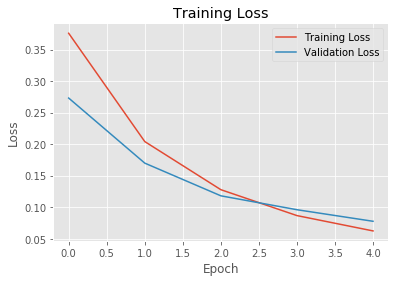

In [15]:
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="Training Loss")
plt.plot(N, H.history["val_loss"], label="Validation Loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [16]:
model = keras.models.load_model(KERAS_MODEL_FILE)

predictions = model.predict_generator(validation_generator, steps=validation_generator.samples / validation_generator.batch_size)
predictions = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes
class_labels = validation_generator.class_indices.keys()

import sklearn.metrics as metrics
print(metrics.confusion_matrix(y_true=true_classes, y_pred=predictions))
print(metrics.classification_report(true_classes, predictions))

[[281  64   0]
 [  3 701  64]
 [ 65   3 433]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       345
           1       0.91      0.91      0.91       768
           2       0.87      0.86      0.87       501

    accuracy                           0.88      1614
   macro avg       0.86      0.86      0.86      1614
weighted avg       0.88      0.88      0.88      1614



In [ ]:
import keract

from keras.preprocessing.image import img_to_array
from PIL import Image

image = Image.open('/home/sam/Documents/Workspace/bad-cat/train_images/ripley/Cat Cam-20190813-132600-1565659560-82.jpg')
image = image.resize((224, 224))
image = img_to_array(image)
image_arr = np.array(image)
image = image.reshape(1, *image.shape)
image = mobilenet_v2.preprocess_input(image)

model = keras.models.load_model(KERAS_MODEL_FILE)
activations = keract.get_activations(model, image)
keract.display_activations(activations)
keract.display_heatmaps(activations, image_arr)